## Applying Unsupervised Learning Methods to World Bank Data (Sustainable Development Goals)

This notebook groups countries into clusters based on data from their Sustainable Development Goals (SDG) indicators, using the mean values from 2014 - 2016. It starts by considering all countries and indicators, then filters out indicators for which many countries have no data, then discards countries with no data for the selected indicators, then visualises the results. The clusters may not be indicative of true groupings according to the SDG, as they are dependent on the selected indicators which are only a small subset of the full SDG set due to incomplete data.

#### Set Desired Constants

In [1]:
dim = 3 # number of dimensions for charts: 2 or 3
k = 5 # number of clusters

#### Load Raw Data

In [2]:
import os
import pandas as pd
from pprint import pprint
from datetime import datetime
import wbdata
from six import iterkeys, itervalues, iteritems
import numpy as np
np.random.seed(1337)

data_filename = "wbdata.csv"

if os.path.isfile(data_filename):
    rawdf = pd.read_csv(data_filename)
    rawdf = rawdf.set_index(['country_name', 'country_code', 'date'])
else:
    # pprint([(i["id"], i["name"]) for i in wbdata.get_source()])
    # indicators = {'NY.GDP.PCAP.PP.CD':'GDP per capita, PPP (current international $)', 'VC.IHR.PSRC.P5':'Intentional homicides (per 100,000 people)'}
    indicators = {i["id"]:i["name"] for i in wbdata.get_indicator(source=46, display=False)}
    
    # countries = ["US","GB"]
    # countries = u'all' # results in junk rows somehow
    wbcountrydata = wbdata.get_country(display=False)
    countries = [i['iso2Code'] for i in wbcountrydata if i["region"]["value"] != "Aggregates"]
    country_codes_dict = {i['name'].replace(u"\u2019", "'"):i['id'] for i in wbcountrydata}

    date_range = (datetime(2012, 1, 1), datetime(2016, 12, 31))
    
    # rawdf = wbdata.get_dataframe(indicators, country=countries, data_date=date_range)
    rawdfs = {}
    for code,name in indicators.iteritems():
        try:
            rawdfs[code] = pd.DataFrame(wbdata.get_data(code, country=countries, data_date=date_range, pandas=True, column_name=name))
        except TypeError as e:
            print("{} - {}: {}".format(code, name, e))
    rawdf = pd.concat(rawdfs.itervalues(), axis=1)

    # rawdf.index.set_levels([i.encode("utf-8") for i in rawdf.index.levels[0]], level=0, inplace=True)
    rawdf.index.set_levels([i.replace(u"\u2019", "'") for i in rawdf.index.levels[0]], level=0, inplace=True)
    
    rawdf.index.set_names('country_name', level=0, inplace=True)
    rawdf["country_code"] = [country_codes_dict[i] for i in rawdf.index.get_level_values(0)]
    rawdf = rawdf.set_index(['country_code'], append=True).reorder_levels([0, 2, 1])
    
    rawdf.to_csv(data_filename)

#### Process Data

In [3]:
df = rawdf.copy()
df = df.drop([2012, 2013], level=2, axis=0)
df = df.mean(level=[0, 1])
df = df.drop([k for k,v in df.isnull().sum().iteritems() if v > (0.12 * len(df))], 1)

# Display currently available indicators
# for i in sorted(df.columns.tolist()):
#     print(i)

# Manually filter indicators to remove duplicate features
selectedIndicators = [
    "Access to electricity (% of population)",
    "Adolescent fertility rate (births per 1,000 women ages 15-19)",
    "Bird species, threatened",
    "Capture fisheries production (metric tons)",
    "Duration of compulsory education (years)",
    "Energy intensity level of primary energy (MJ/$2011 PPP GDP)",
    "Fish species, threatened",
    "Foreign direct investment, net inflows (BoP, current US$)",
    "Forest area (% of land area)",
    "Forest rents (% of GDP)",
    "GDP per capita (constant 2010 US$)",
    "GDP per capita growth (annual %)",
    "Immunization, DPT (% of children ages 12-23 months)",
    "Immunization, measles (% of children ages 12-23 months)",
    "Improved sanitation facilities (% of population with access)",
    "Improved water source (% of population with access)",
    "Incidence of tuberculosis (per 100,000 people)",
    "Individuals using the Internet (% of population)",
    "Mammal species, threatened",
    "Marine protected areas (% of territorial waters)",
    "Mineral rents (% of GDP)",
    "Mortality rate, neonatal (per 1,000 live births)",
    "Mortality rate, under-5 (per 1,000 live births)",
    "PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)",
    "PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)",
    "Plant species (higher), threatened",
    "Preprimary education, duration (years)",
    "Proportion of seats held by women in national parliaments (%)",
    "Renewable electricity output (% of total electricity output)",
    "Renewable energy consumption (% of total final energy consumption)",
    "Terrestrial and marine protected areas (% of total territorial area)",
    "Terrestrial protected areas (% of total land area)",
    "Theoretical duration of primary education (years)",
    "Theoretical duration of secondary education (years)",
    "Total fisheries production (metric tons)",
    "Total natural resources rents (% of GDP)",
    "Urban population",
    "Urban population growth (annual %)",
]
df = df[selectedIndicators]

df = df.dropna()
country_names = df.index.get_level_values(0).tolist()
country_codes = df.index.get_level_values(1).tolist()

#### Define Chart Plotting Functions

In [4]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D # necessary for 3d though not directly used

from plotly import offline as pyoffline
import plotly.graph_objs as go
pyoffline.init_notebook_mode(connected=True)

def plotMat(names, reduced, class_list):
    fig = plt.figure()
    if dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        tup = (reduced[:, 0], reduced[:, 1], reduced[:, 2])
        for i, name in enumerate(names):
            ax.text(reduced[i, 0], reduced[i, 1], reduced[i, 2], name, size=10, zorder=-1)
    else:
        ax = fig.add_subplot(111)
        tup = (reduced[:, 0], reduced[:, 1])
        for i, name in enumerate(names):
            ax.annotate(name, xy=(reduced[i, 0], reduced[i, 1]), xytext=(5, 0), textcoords='offset points')
    ax.set_title("Countries")
    ax.scatter(*tup, c=class_list, cmap=plt.cm.spectral)
    plt.show()

def plotLy(names, reduced, class_list, anomalies, is_anomaly):
    trace1 = dict(
        type="scatter",
        x=reduced[:, 0],
        y=reduced[:, 1],
        mode='markers',
        text=["{}, Cluster #{}{}".format(a,b," (Anomaly)" if is_anomaly(c) else "") for a,b,c in zip(names, class_list, anomalies)],
        marker=dict(
            size=6,
            symbol=["x" if is_anomaly(i) else "circle" for i in anomalies],
            color=class_list,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(
                tickmode="array",
                title="Cluster",
                tickvals=[i for i in range(k)],
                ticktext=["#{}".format(i) for i in range(k)],
            ),
            opacity=0.5
        )
    )
    if dim == 3:
        trace1["z"] = reduced[:, 2]
        trace1["type"] = "scatter3d"
        trace1["marker"]["size"] = 3
    data = [trace1]
    layout = go.Layout(
        title="Countries",
        margin=dict(
            l=0,
            r=0,
            b=0
        )
    )
    fig = go.Figure(data=data, layout=layout)
    pyoffline.iplot(fig, show_link=False)

def drawMap(locs, names, values):
    trace = dict(
        type = 'choropleth',
        locations = locs,
        z = values,
        text = names,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            )
        ),
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(
            tickmode="array",
            title="Cluster",
            tickvals=[i for i in range(k)],
            ticktext=["#{}".format(i) for i in range(k)],
        ),
    )

    layout = dict(
        geo = dict(
            showframe = True,
            showcoastlines = False,
            projection = dict(
                type = 'Mercator'
            )
        )
    )

    fig = go.Figure(data=[trace], layout=layout)
    pyoffline.iplot(fig, show_link=False)

#### Run Unsupervised Learning Methods

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.svm import OneClassSVM
from lsanomaly import LSAnomaly

scaled = scale(df)

# pipe = Pipeline([
#     ('pca', PCA(n_components=dim)),
#     ('km', KMeans(n_clusters=k, n_init=100)),
# ])
# reduced = pipe.fit_transform(scaled)
# clusters = pipe.predict(scaled)

reduced = PCA(n_components=dim).fit_transform(scaled)
# reduced = TSNE(n_components=dim).fit_transform(scaled)

clusters = KMeans(n_clusters=k, n_init=100).fit(scaled).predict(scaled)

# anomalies = OneClassSVM().fit(scaled).predict(scaled)
# is_anomaly = lambda x: x<0
anom = LSAnomaly(rho=1)
anom.fit(df.as_matrix())
anomalies = anom.predict(df)
is_anomaly = lambda x: x == "anomaly"

/srv/app/venv/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning:

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.



#### Plot with matplotlib

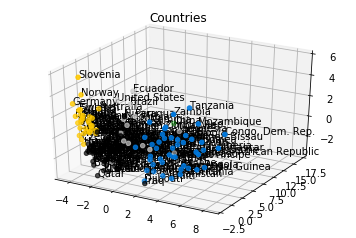

In [6]:
plotMat(country_names, reduced, clusters)

#### Plot with plotly

In [7]:
plotLy(country_names, reduced, clusters, anomalies, is_anomaly)

#### Geographic plot

In [8]:
drawMap(country_codes, country_names, clusters)

#### Display indicators used

In [9]:
for i in sorted(df.columns.tolist()):
    print(i)

Access to electricity (% of population)
Adolescent fertility rate (births per 1,000 women ages 15-19)
Bird species, threatened
Capture fisheries production (metric tons)
Duration of compulsory education (years)
Energy intensity level of primary energy (MJ/$2011 PPP GDP)
Fish species, threatened
Foreign direct investment, net inflows (BoP, current US$)
Forest area (% of land area)
Forest rents (% of GDP)
GDP per capita (constant 2010 US$)
GDP per capita growth (annual %)
Immunization, DPT (% of children ages 12-23 months)
Immunization, measles (% of children ages 12-23 months)
Improved sanitation facilities (% of population with access)
Improved water source (% of population with access)
Incidence of tuberculosis (per 100,000 people)
Individuals using the Internet (% of population)
Mammal species, threatened
Marine protected areas (% of territorial waters)
Mineral rents (% of GDP)
Mortality rate, neonatal (per 1,000 live births)
Mortality rate, under-5 (per 1,000 live births)
PM2.5 air 